In [1]:
import os
import pickle

import geopandas as gpd
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import polars
import polars as pl
import pyvisgraph as vg
from shapely import unary_union, wkt
from tqdm import tqdm

In [2]:
def create_grid_visualization(df):
    # グリッドの次元を取得
    x_max = df["grid_x"].max() + 1
    y_max = df["grid_y"].max() + 1

    # 2D配列に変換
    grid = np.zeros((y_max, x_max))
    for row in df.iter_rows():
        x, y, cost = row
        grid[y, x] = cost

    # プロットの作成
    plt.figure(figsize=(12, 8))

    # pcolormeshでヒートマップを描画
    im = plt.pcolormesh(grid, cmap="viridis", shading="auto")

    # カラーバーを追加

    plt.colorbar(im, label="Cost(分)")

    # 軸ラベルを設定
    plt.xlabel("Grid X")
    plt.ylabel("Grid Y")
    plt.title("Tobler's hiking function")

    # グリッドを表示
    plt.grid(True)

    return plt

In [3]:
def get_site_grid_coords(
    df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame
) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換

    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム

    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
        df_obsidian.select([(pl.col("遺跡ID")), (pl.col("緯度")), (pl.col("経度"))])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
        .with_columns(
            [
                ((pl.col("経度") - (x_first_center - (x_spacing / 2))) / x_spacing)
                .cast(pl.Int64)
                .alias("grid_x"),
                ((pl.col("緯度") - (y_first_center - (y_spacing / 2))) / y_spacing)
                .cast(pl.Int64)
                .alias("grid_y"),
            ]
        )
    )

    site_grid_coords = np.column_stack(
        [coords["grid_x"].to_numpy(), coords["grid_y"].to_numpy()]
    )

    return site_grid_coords

In [4]:
SCHEMA = pl.Schema(
    {
        "grid_x": pl.Int64,
        "x": pl.Float64,
        "grid_y": pl.Int64,
        "y": pl.Float64,
        "mesh_code_5th": pl.Int64,
        "average_elevation": pl.Float64,
        "maximum_elevation": pl.Float64,
        "minimum_elevation": pl.Float64,
        "minimum_elevation_code": pl.Int64,
        "maximum_slope_angle": pl.Float64,
        "maximum_slope_direction": pl.Int64,
        "minimum_slope_angle": pl.Float64,
        "minimum_slope_direction": pl.Int64,
        "average_slope_angle": pl.Float64,
        "geometry": pl.Utf8,
        "is_sea": pl.Boolean,
        "walking_velocity": pl.Float64,
        "travel_time": pl.Float64,
        "elevation_diff_east": pl.Float64,
        "angle_east": pl.Float64,
        "walking_velocity_east": pl.Float64,
        "travel_time_east": pl.Float64,
        "elevation_diff_west": pl.Float64,
        "angle_west": pl.Float64,
        "walking_velocity_west": pl.Float64,
        "travel_time_west": pl.Float64,
        "elevation_diff_north": pl.Float64,
        "angle_north": pl.Float64,
        "walking_velocity_north": pl.Float64,
        "travel_time_north": pl.Float64,
        "elevation_diff_south": pl.Float64,
        "angle_south": pl.Float64,
        "walking_velocity_south": pl.Float64,
        "travel_time_south": pl.Float64,
        "cost_kouzu": pl.Float64,
        "cost_shinshu": pl.Float64,
        "cost_hakone": pl.Float64,
        "cost_takahara": pl.Float64,
        "cost_river": pl.Float64,
        "x_meter": pl.Float64,
        "y_meter": pl.Float64,
    }
)

data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"],  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
    # 全く欠損していない行をis_validとする
    .with_columns(
        [
            pl.all_horizontal(
                [~pl.col(col).is_null() for col in df_elevation.columns]
            ).alias("is_valid")
        ]
    )
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


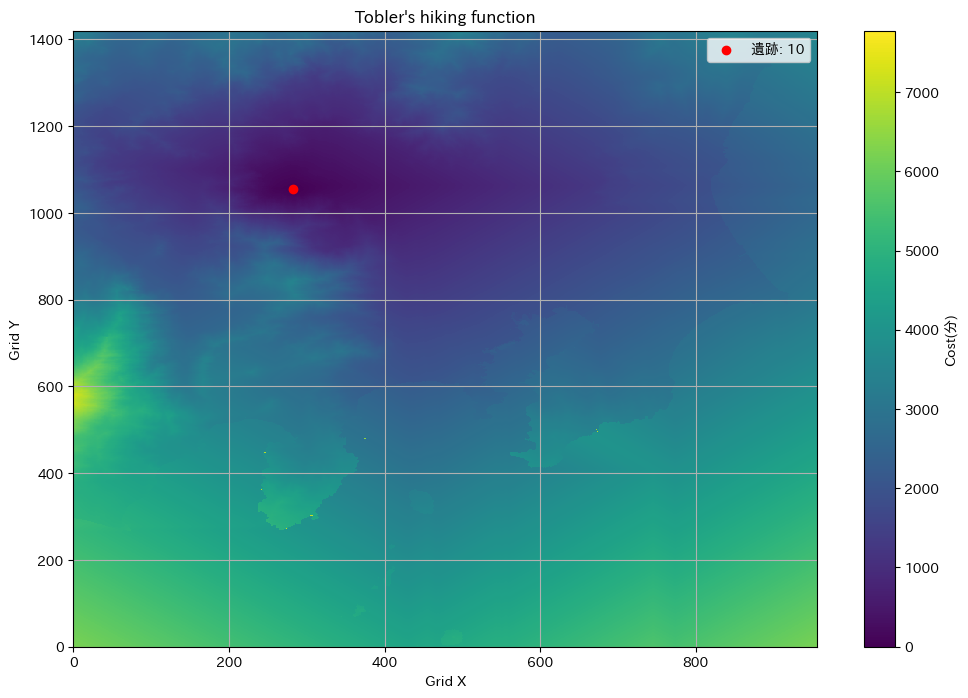

In [5]:
i = 10

x = site_grid_coords[i, 0]
y = site_grid_coords[i, 1]

### pickleで保存したファイルを読み込み
with open(
    os.path.join(
        data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"
    ),
    mode="br",
) as fi:
    min_costs = pickle.load(fi)

width = 956
height = 1420

# grid_x, grid_y, min_cost_minutsという列を持つpl.DataFrameを作成
min_costs_df = pl.DataFrame(
    {
        "grid_x": np.tile(np.arange(width), height),
        "grid_y": np.repeat(np.arange(height), width),
        f"cost_{i}": min_costs,
    }
)

# 使用例:
plt_ = create_grid_visualization(min_costs_df)
plt_.scatter(x, y, color="red", label=f"遺跡: {i}")
plt_.legend()
plt_.show()

### 説明変数を入れてカーネル回帰とIPPを同時推定

In [6]:
import os
from typing import Tuple

import numpy as np
import polars as pl

In [7]:
# 地点ごとの産地構成比を計算


def preprocess_data(
    df: pl.DataFrame, target_period: int, target_origin: str
) -> Tuple[np.ndarray, np.ndarray]:
    """
    解析用のデータを前処理

    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
    target_period : int
        対象時期
    target_origin : str
        対象産地カテゴリ

    Returns
    -------
    counts : np.ndarray
        各遺跡での出土数（インデックスが遺跡ID）
    target_counts : np.ndarray
        対象産地の出土数（インデックスが遺跡ID）
    """
    # 全遺跡IDのリストを取得
    max_site_id = df["遺跡ID"].max()

    # 対象時期のデータのみ抽出
    period_df = df.filter(pl.col("時期") == target_period)

    # 全体のカウント
    counts = (
        period_df.group_by("遺跡ID")
        .agg([pl.len().alias("count")])
        .join(
            pl.DataFrame({"遺跡ID": np.arange(max_site_id + 1)}),
            on="遺跡ID",
            how="right",
        )
        .fill_null(0)
        .sort("遺跡ID")["count"]
        .to_numpy()
    )

    # 対象産地のカウント
    target_counts = (
        period_df.filter(pl.col("産地カテゴリ") == target_origin)
        .group_by("遺跡ID")
        .agg([pl.len().alias("count")])
        .join(
            pl.DataFrame({"遺跡ID": np.arange(max_site_id + 1)}),
            on="遺跡ID",
            how="right",
        )
        .fill_null(0)
        .sort("遺跡ID")["count"]
        .to_numpy()
    )

    return counts, target_counts

In [8]:
def create_site_coords(df: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をラジアンに変換

    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム

    Returns
    -------
    np.ndarray
        遺跡の座標（ラジアン）
    """
    # 座標をラジアンに変換
    coords = (
        df.select(
            [
                (pl.col("遺跡ID")),
                (pl.col("緯度") * np.pi / 180).alias("lat_rad"),
                (pl.col("経度") * np.pi / 180).alias("lon_rad"),
            ]
        )
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
    )

    # 座標と出土数を numpy 配列に変換
    site_coords = np.column_stack(
        [coords["lat_rad"].to_numpy(), coords["lon_rad"].to_numpy()]
    )

    return site_coords

In [9]:
def get_site_grid_coords(
    df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame
) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換

    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム

    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
        df_obsidian.select([(pl.col("遺跡ID")), (pl.col("緯度")), (pl.col("経度"))])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
        .with_columns(
            [
                ((pl.col("経度") - (x_first_center - (x_spacing / 2))) / x_spacing)
                .cast(pl.Int64)
                .alias("grid_x"),
                ((pl.col("緯度") - (y_first_center - (y_spacing / 2))) / y_spacing)
                .cast(pl.Int64)
                .alias("grid_y"),
            ]
        )
    )

    site_grid_coords = np.column_stack(
        [coords["grid_x"].to_numpy(), coords["grid_y"].to_numpy()]
    )

    return site_grid_coords

In [10]:
# 重みの初期計算
def K(x, sigma):
    return np.exp(-0.5 * (x**2) / (sigma**2)) / (2 * np.pi * sigma**2)


def calculate_weights_matrix(
    grid_coords: np.ndarray,  # (グリッド数, 2)
    site_coords: np.ndarray,  # (遺跡数, 2)
    sigma: float,
) -> np.ndarray:  # (グリッド数, 遺跡数)
    """
    重み行列を計算
    """
    R = 6371  # 地球の半径(km)

    # 通常の距離計算
    dlat = grid_coords[:, np.newaxis, 0] - site_coords[np.newaxis, :, 0]
    dlon = grid_coords[:, np.newaxis, 1] - site_coords[np.newaxis, :, 1]

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(grid_coords[:, np.newaxis, 0])
        * np.cos(site_coords[np.newaxis, :, 0])
        * np.sin(dlon / 2) ** 2
    )

    distances = 2 * R * np.arcsin(np.sqrt(a))

    weights = K(distances, sigma)

    return weights

In [11]:
def calculate_distance_W(
    W_grid: np.ndarray,
    W_sites: np.ndarray,
) -> np.ndarray:
    """
    説明変数間の距離行列を計算

    Parameters
    ----------
    W_grid : np.ndarray
        グリッドの説明変数 (グリッド数, p)
    W_sites : np.ndarray
        遺跡の説明変数 (遺跡数, p)

    p は説明変数の次元数

    Returns
    -------
    np.ndarray
        説明変数間の距離行列 (グリッド数, 遺跡数, p)
    """
    # W_gridを(グリッド数, 1, p)に、W_sitesを(1, 遺跡数, p)に reshape
    # ブロードキャストにより自動的に(グリッド数, 遺跡数, p)に拡張される
    W_grid_expanded = W_grid[:, np.newaxis, :]
    W_sites_expanded = W_sites[np.newaxis, :, :]

    # ユークリッド距離の計算
    distances = np.abs(W_grid_expanded - W_sites_expanded)

    return distances

In [12]:
def create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh):
    # 地形マスクの作成
    land_points = df_elevation.select(
        ["x", "y", pl.col("is_sea").cast(pl.Boolean)]
    ).to_numpy()

    lons_1d = lon_mesh[0, :]
    lats_1d = lat_mesh[:, 0]
    land_mask = np.full(lon_mesh.shape, False)

    x_indices = np.searchsorted(lons_1d, land_points[:, 0])
    y_indices = np.searchsorted(lats_1d, land_points[:, 1])
    valid_points = (
        (x_indices > 0)
        & (x_indices < len(lons_1d))
        & (y_indices > 0)
        & (y_indices < len(lats_1d))
    )
    is_sea = land_points[valid_points, 2].astype(bool)
    land_mask[y_indices[valid_points], x_indices[valid_points]] = ~is_sea

    # grid_coordsの各点について、対応するland_maskの値を取得
    grid_lons = grid_coords[:, 1] * 180 / np.pi  # ラジアンから度に変換
    grid_lats = grid_coords[:, 0] * 180 / np.pi

    grid_x_indices = np.searchsorted(lons_1d, grid_lons)
    grid_y_indices = np.searchsorted(lats_1d, grid_lats)

    # インデックスが有効範囲内にあることを確認
    valid_grid_points = (
        (grid_x_indices > 0)
        & (grid_x_indices < len(lons_1d))
        & (grid_y_indices > 0)
        & (grid_y_indices < len(lats_1d))
    )

    # 海上の点の重みを0に設定
    grid_is_land = np.zeros(len(grid_coords), dtype=bool)
    grid_is_land[valid_grid_points] = land_mask[
        grid_y_indices[valid_grid_points], grid_x_indices[valid_grid_points]
    ]

    return grid_is_land

In [13]:
def calculate_ratios(
    weights: np.ndarray, counts: np.ndarray, target_counts: np.ndarray
) -> np.ndarray:
    """
    重み付き比率を計算

    Parameters
    ----------
    weights : np.ndarray
        重み行列
    counts : np.ndarray
        各遺跡での出土数
    target_counts : np.ndarray
        対象産地の出土数

    Returns
    -------
    ratios : np.ndarray
        各グリッド点での重み付き比率
    """
    # 重み付き合計を計算
    weighted_total = np.sum(weights * counts, axis=1)
    weighted_target = np.sum(weights * target_counts, axis=1)

    # 比率計算（0除算を防ぐ）
    ratios = np.where(weighted_total > 0, weighted_target / weighted_total, 0)

    return ratios

In [14]:
def plot_contour(
    df,
    x_col="x",
    y_col="y",
    value_col="cost_kouzu",
    figsize=(12, 8),
    plot_probability=False,
    n_levels=30,
    cmap="Blues",
):
    # まず海陸判定のマスクを作成
    mask = df.with_columns((~pl.col("is_sea")).alias("is_not_sea")).pivot(
        values="is_not_sea", on=x_col, index=y_col
    )

    # 値のピボットテーブルを作成
    grid_data = df.pivot(values=value_col, on=x_col, index=y_col)

    # マスクを適用（y_col列は保持）
    grid_data = grid_data.with_columns(
        [
            pl.col(col) * mask.get_column(col)
            for col in grid_data.columns
            if col != y_col
        ]
    )

    # メッシュグリッドの作成
    x_mesh = np.array(grid_data.columns[1:], dtype=float)
    y_mesh = np.array(grid_data.to_numpy()[:, 0], dtype=float)
    values_mesh = grid_data.to_numpy()[:, 1:]

    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)

    if plot_probability:
        # 確率表示モード（0-1の範囲）
        contour = ax.contourf(
            x_mesh,
            y_mesh,
            values_mesh,
            levels=np.linspace(0, 1, n_levels + 1),
            cmap=cmap,
            alpha=0.7,
            vmin=0,
            vmax=1,
        )
    else:
        # 通常モード（データをそのまま使用）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh, levels=n_levels, cmap=cmap, alpha=0.7
        )

    # カラーバーの追加
    if plot_probability:
        # カラーバー（0-1の範囲に固定）
        plt.colorbar(contour, ax=ax, label="Ratio", ticks=np.linspace(0, 1, 6))
    else:
        plt.colorbar(contour, ax=ax)

    # ラベルの設定
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")

    return fig, ax

In [15]:
SCHEMA = pl.Schema(
    {
        "grid_x": pl.Int64,
        "x": pl.Float64,
        "grid_y": pl.Int64,
        "y": pl.Float64,
        "mesh_code_5th": pl.Int64,
        "average_elevation": pl.Float64,
        "maximum_elevation": pl.Float64,
        "minimum_elevation": pl.Float64,
        "minimum_elevation_code": pl.Int64,
        "maximum_slope_angle": pl.Float64,
        "maximum_slope_direction": pl.Int64,
        "minimum_slope_angle": pl.Float64,
        "minimum_slope_direction": pl.Int64,
        "average_slope_angle": pl.Float64,
        "geometry": pl.Utf8,
        "is_sea": pl.Boolean,
        "walking_velocity": pl.Float64,
        "travel_time": pl.Float64,
        "elevation_diff_east": pl.Float64,
        "angle_east": pl.Float64,
        "walking_velocity_east": pl.Float64,
        "travel_time_east": pl.Float64,
        "elevation_diff_west": pl.Float64,
        "angle_west": pl.Float64,
        "walking_velocity_west": pl.Float64,
        "travel_time_west": pl.Float64,
        "elevation_diff_north": pl.Float64,
        "angle_north": pl.Float64,
        "walking_velocity_north": pl.Float64,
        "travel_time_north": pl.Float64,
        "elevation_diff_south": pl.Float64,
        "angle_south": pl.Float64,
        "walking_velocity_south": pl.Float64,
        "travel_time_south": pl.Float64,
        "cost_kouzu": pl.Float64,
        "cost_shinshu": pl.Float64,
        "cost_hakone": pl.Float64,
        "cost_takahara": pl.Float64,
        "cost_river": pl.Float64,
        "x_meter": pl.Float64,
        "y_meter": pl.Float64,
    }
)

In [16]:
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"],  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
    # 全く欠損していない行をis_validとする
    .with_columns(
        [
            pl.all_horizontal(
                [~pl.col(col).is_null() for col in df_elevation.columns]
            ).alias("is_valid")
        ]
    )
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

time_period_name = {0: "早期・早々期", 1: "前期", 2: "中期", 3: "後期", 4: "晩期"}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

sigma = 500
sigma_for_sites = 0.1

# =======================================================================================

# メッシュグリッドを作成
lon_mesh, lat_mesh = np.meshgrid(
    df_elevation["x"].unique().sort(),  # 経度の一意な値
    df_elevation["y"].unique().sort(),  # 緯度の一意な値
)

print(lon_mesh.shape, lat_mesh.shape)

# 遺跡の位置: (遺跡数, 2)
site_coords = create_site_coords(df_obsidian)

# グリッドの位置座標: (グリッド数, 2)
grid_coords = np.column_stack(
    [lat_mesh.ravel() * np.pi / 180, lon_mesh.ravel() * np.pi / 180]
)

(1420, 956) (1420, 956)


In [17]:
df_sites = df_sites.join(
    df_elevation.drop(["x", "y"]).with_columns(
        [pl.col("mesh_code_5th").cast(pl.Int64).alias("mesh_code_5th")]
    ),
    left_on="メッシュコード",
    right_on="mesh_code_5th",
    how="left",
)

## 説明変数を入れたcoordsを作成する

In [18]:
# 説明変数の一覧
variable_names = [
    "average_elevation",
    "average_slope_angle",
    "cost_kouzu",
    "cost_shinshu",
    "cost_hakone",
    "cost_takahara",
    "cost_river",
]

# grid_coordsに対応する形で説明変数を取得: (グリッド数, p)
W_grids = (
    df_elevation.sort(["y", "x"]).select(variable_names).to_numpy().astype(np.float64)
)

# site_coordsに対応する形で説明変数を取得: (遺跡数, p)
W_sites = df_sites.sort("遺跡ID").select(variable_names).to_numpy().astype(np.float64)

In [19]:
# ====================
# 距離行列を読み込む
# ====================

# 距離行列の読み込み
### pickleで保存したファイルを読み込み

distances = np.zeros((len(grid_coords), len(site_coords)))
for i in range(len(site_coords)):
    with open(
        os.path.join(
            data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"
        ),
        mode="br",
    ) as fi:
        min_costs = pickle.load(fi)
        distances[:, i] = min_costs

In [20]:
# ====================
# 重み行列を計算
# ====================

weights = K(distances, sigma)

In [21]:
print("creating weights matrix...")
# 陸地のみの重み行列の計算
# weights = calculate_weights_matrix(
#    grid_coords, site_coords, sigma
# )

# 説明変数間の距離行列の計算
print("calculating distance_W...")
distance_W = calculate_distance_W(W_grids, W_sites)

weights_W = K(distance_W, sigma).prod(axis=2)

weights *= weights_W

print("updating weights matrix...")

# 重みの更新
grid_is_land = create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh)

# 海上の点からの重みをすべて0に
weights *= grid_is_land[:, np.newaxis]

# 遺跡についての計算 ============================================================================

# 遺跡の一意な地点を取得
unique_sites = df_obsidian.unique(subset=["遺跡ID"]).sort("遺跡ID")

# 計算対象の遺跡の座標をラジアンに変換
target_coords_sites = np.column_stack(
    [
        unique_sites["緯度"].to_numpy() * np.pi / 180,
        unique_sites["経度"].to_numpy() * np.pi / 180,
    ]
)

creating weights matrix...
calculating distance_W...
updating weights matrix...


In [22]:
# ============================
# sites同士の距離行列を計算
# ============================

site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)


def idx(x, y):
    return y * width + x


# distancesは(グリッド数, 遺跡数)の形状なので、i=idx(site_grid_coords)として、distances[i]をスライスすれば、(遺跡数, 遺跡数)の形状になる
site_grid_idx = np.vectorize(idx)(site_grid_coords[:, 0], site_grid_coords[:, 1])

distances_sites = distances[site_grid_idx]
weights_sites = K(distances_sites, sigma_for_sites)

In [23]:
weights.shape, weights_sites.shape

((1357520, 274), (274, 274))

In [24]:
# target_period = 0で実験
target_period = 0
counts_all = np.zeros((len(site_coords), len(origin_order) - 1))
for i, origin in enumerate(origin_order[:-1]):
    counts, target_counts = preprocess_data(df_obsidian, target_period, origin)
    counts_all[:, i] = target_counts

In [25]:
(
    site_coords.shape,
    counts_all.shape,
    W_sites.shape,
    distances_sites.shape,
    grid_coords.shape,
    distances.shape,
    W_grids.shape,
)

((274, 2),
 (274, 4),
 (274, 7),
 (274, 274),
 (1357520, 2),
 (1357520, 274),
 (1357520, 7))

In [26]:
"""
ratio_df = pl.DataFrame({
    'x': lon_mesh.ravel(),
    'y': lat_mesh.ravel()
})

ratio_sites_df = pl.DataFrame({
    '遺跡ID': df_sites['遺跡ID']
})

target_period = 0
target_origin = "神津島"

print(f"target_period: {target_period}, target_origin: {target_origin}")

# ここからtarget_period, target_originに依存する処理
counts, target_counts = preprocess_data(
    df_obsidian, target_period, target_origin
)

# 重み付き比率の計算
ratio_mesh = calculate_ratios(weights, counts, target_counts).reshape(lon_mesh.shape)

ratio_df = ratio_df.join(
    pl.DataFrame({
        'x': lon_mesh.ravel(),
        'y': lat_mesh.ravel(),
        f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel()
    }),
    on=["x", "y"]
)

# 比率の計算
ratios = calculate_ratios(weights_sites, counts, target_counts)

ratio_sites_df = ratio_sites_df.join(
    pl.DataFrame({
        '遺跡ID': unique_sites['遺跡ID'],
        f"比率_{target_period}_{target_origin}": ratios
    }),
    on="遺跡ID"
)

df_elevation = df_elevation.join(
    ratio_df,
    on=["x", "y"]
)
df_sites = df_sites.join(
    ratio_sites_df,
    on="遺跡ID"
)
"""

'\nratio_df = pl.DataFrame({\n    \'x\': lon_mesh.ravel(),\n    \'y\': lat_mesh.ravel()\n})\n\nratio_sites_df = pl.DataFrame({\n    \'遺跡ID\': df_sites[\'遺跡ID\']\n})\n\ntarget_period = 0\ntarget_origin = "神津島"\n\nprint(f"target_period: {target_period}, target_origin: {target_origin}")\n\n# ここからtarget_period, target_originに依存する処理\ncounts, target_counts = preprocess_data(\n    df_obsidian, target_period, target_origin\n)\n\n# 重み付き比率の計算\nratio_mesh = calculate_ratios(weights, counts, target_counts).reshape(lon_mesh.shape)\n\nratio_df = ratio_df.join(\n    pl.DataFrame({\n        \'x\': lon_mesh.ravel(),\n        \'y\': lat_mesh.ravel(),\n        f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel()\n    }),\n    on=["x", "y"]\n)\n\n# 比率の計算\nratios = calculate_ratios(weights_sites, counts, target_counts)\n\nratio_sites_df = ratio_sites_df.join(\n    pl.DataFrame({\n        \'遺跡ID\': unique_sites[\'遺跡ID\'],\n        f"比率_{target_period}_{target_origin}": ratios\n    }),\n    on="遺跡ID"

In [27]:
# ------------- 元データ -------------
# site_coords      : (274, 2)
# counts_all       : (274, 4)     ← k=1…4 = [kouzu, shinshu, hakone, takahara]
# W_sites          : (274, 7)     ← col0: elevation, col1: slope,
#                                    col2–5: cost_kouzu…takahara,
#                                    col6: cost_river
# grid_coords      : (1357520, 2)
# W_grids          : (1357520, 7) ← 同じ列順

# ------------- 距離列を抽出 -------------
g_dists_sites = W_sites[:, 2:6]  # (N, 4)
g_dists_grid = W_grids[:, 2:6]  # (M, 4)

# ------------- 残りの共変量 (Z) -------------
Z_sites = np.column_stack([W_sites[:, 0:2], W_sites[:, 6]])  # (N, 3)
Z_grids = np.column_stack([W_grids[:, 0:2], W_grids[:, 6]])  # (M, 3)

# 実装

In [28]:
# ------------------------------------------------------------------------------------
# Cell 1 : imports
# ------------------------------------------------------------------------------------
import numpy as np
from numpy.linalg import inv
from pypolyagamma import PyPolyaGamma  # PG RNG
from scipy.linalg import cho_solve, cholesky
from scipy.spatial.distance import cdist

pg_rng = PyPolyaGamma()


def pg_draw_vec(b_vec, c_vec):
    """vectorized Polya–Gamma draws"""
    return np.array(
        [pg_rng.pgdraw(b, c) for b, c in zip(b_vec, c_vec)], dtype=np.float64
    )

In [29]:
# ------------------------------------------------------------------------------------
# Cell 2 : load data & build covariate matrix (3 geom + 4 distance) + SB bookkeeping
# ------------------------------------------------------------------------------------
site_coords = site_coords  # (N,2)
counts_all = counts_all  # (N,K)
grid_coords = grid_coords  # (M,2)

# ---------- 共変量 ----------
# geom : elevation(0), slope(1), river(6)
# dist : kouzu(2), shinshu(3), hakone(4), takahara(5)
W_sites = W_sites  # (N,7)
W_grids = W_grids  # (M,7)

geom_sites = W_sites[:, [0, 1, 6]]  # (N,3)
geom_grids = W_grids[:, [0, 1, 6]]

# 距離は log(d+1) 変換後に標準化
dist_sites_raw = np.log(W_sites[:, 2:6] + 1.0)  # (N,4)
dist_grids_raw = np.log(W_grids[:, 2:6] + 1.0)

# --- 結合 before z‑score ---
cov_sites_raw = np.column_stack([geom_sites, dist_sites_raw])  # (N,7)
cov_grids_raw = np.column_stack([geom_grids, dist_grids_raw])  # (M,7)

# --- z‑score 標準化 (サイト統計で共通) ---
mu_z = cov_sites_raw.mean(0)  # (7,)
sd_z = cov_sites_raw.std(0, ddof=0)  # (7,)

cov_sites = (cov_sites_raw - mu_z) / sd_z
cov_grids = (cov_grids_raw - mu_z) / sd_z

p = cov_sites.shape[1]  # p = 7

# ---------- SB bookkeeping ----------
N, K = counts_all.shape
N_i = counts_all.sum(1).astype(int)
m_all = np.zeros((N, K - 1), dtype=int)
for k in range(K - 1):
    m_all[:, k] = N_i - counts_all[:, :k].sum(1)

In [30]:
# ------------------------------------------------------------------------------------
# Cell 3 : mixed kernel with ARD (p=7)
# ------------------------------------------------------------------------------------
def mixed_kernel_ard(Xs1, Xs2, Z1, Z2, tau2, rho_s, rho_z_vec):
    d2_space = cdist(Xs1, Xs2, "sqeuclidean") / (rho_s**2)
    diff = Z1[:, None, :] - Z2[None, :, :]  # (n1,n2,p)
    d2_cov = np.sum((diff**2) / (rho_z_vec**2), axis=2)
    return tau2 * np.exp(-0.5 * (d2_space + d2_cov))


# -------- ハイパーパラ ----------
tau2 = 1
rho_s = 0.002
# elevation, slope, river, kouzuDist, shinshuDist, hakoneDist, takaharaDist
rho_z_vec = np.array([1, 1, 1, 1, 1, 1, 1])  # (7,)

eps = 1e-6
K_NN = (
    mixed_kernel_ard(
        site_coords, site_coords, cov_sites, cov_sites, tau2, rho_s, rho_z_vec
    )
    + np.eye(N) * eps
)
L_K = cholesky(K_NN, lower=True)
K_inv = cho_solve((L_K, True), np.eye(N))

In [31]:
# ------------------------------------------------------------------------------------
# Cell 4 : PG‑Gibbs for Multinomial‑GP with Stick‑Breaking
# ------------------------------------------------------------------------------------
n_iter = 400
burn_in = 10
thin = 1
store_ix = np.arange(burn_in, n_iter, thin)

f_store = np.zeros((len(store_ix), N, K - 1))  # latent GP
pi_store = np.zeros((len(store_ix), N, K))

# 初期値
f = np.zeros((N, K - 1))
omega = np.ones((N, K - 1))


def stick_break(psi):  # psi : (N, K-1)
    """Return π (N, K) via logistic stick‑breaking."""
    sig = 1.0 / (1.0 + np.exp(-psi))
    Nn, K1 = psi.shape
    pi = np.zeros((Nn, K1 + 1))
    prod = np.ones(Nn)
    for k in range(K1):
        pi[:, k] = sig[:, k] * prod
        prod *= 1.0 - sig[:, k]
    pi[:, -1] = prod
    return pi


for it in tqdm(range(n_iter)):
    # ---- 1. Polya‑Gamma draws ω & κ ----
    for k in range(K - 1):
        m_k = m_all[:, k]  # (N,)
        kappa_k = counts_all[:, k] - m_k / 2
        omega[:, k] = pg_draw_vec(m_k.astype(np.float64), f[:, k])

        # ---- 2. latent GP f_k | rest ----
        Omega_k = np.diag(omega[:, k])
        V_inv = K_inv + Omega_k
        V = inv(V_inv)
        m_post = V @ kappa_k
        f[:, k] = m_post + cholesky(V) @ np.random.randn(N)

    # ---- 保存 ----
    if it in store_ix:
        idx = np.where(store_ix == it)[0][0]
        f_store[idx] = f
        pi_store[idx] = stick_break(f)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [06:01<00:00,  1.11it/s]


In [32]:
# ------------------------------------------------------------------------------------
# Cell 5 : site‑level posterior mean
# ------------------------------------------------------------------------------------
f_mean = f_store.mean(0)  # (N, K-1)
pi_site_mean = stick_break(f_mean)  # (N, K)

print("Mean category proportions at sites (first 5 rows):")
print(pi_site_mean[:5])

Mean category proportions at sites (first 5 rows):
[[0.49913942 0.2536554  0.1296677  0.11753747]
 [0.49627235 0.2510894  0.12967727 0.12296098]
 [0.48343369 0.26410231 0.12450289 0.12796111]
 [0.52418924 0.24311156 0.1212639  0.11143531]
 [0.48348181 0.27328809 0.12541293 0.11781716]]


In [33]:
# ------------------------------------------------------------------------------------
# Cell 6 : grid prediction using mixed kernel
# ------------------------------------------------------------------------------------
batch = 50_000
M = grid_coords.shape[0]
pi_grid_mean = np.zeros((M, K))

# α = K^{-1} f̄   (N, K-1)
alpha = K_inv @ f_mean

for start in tqdm(range(0, M, batch)):
    end = min(M, start + batch)

    K_N = mixed_kernel_ard(
        grid_coords[start:end],
        site_coords,
        cov_grids[start:end],
        cov_sites,
        tau2,
        rho_s,
        rho_z_vec,
    )
    # (batch,N)

    f_pred = K_N @ alpha  # (batch, K-1)
    pi_grid_mean[start:end] = stick_break(f_pred)

100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


/tmp/ipykernel_3242521/2998177497.py:6: RuntimeWarning: invalid value encountered in divide
  ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)


target_period: 0, target_origin: 神津島


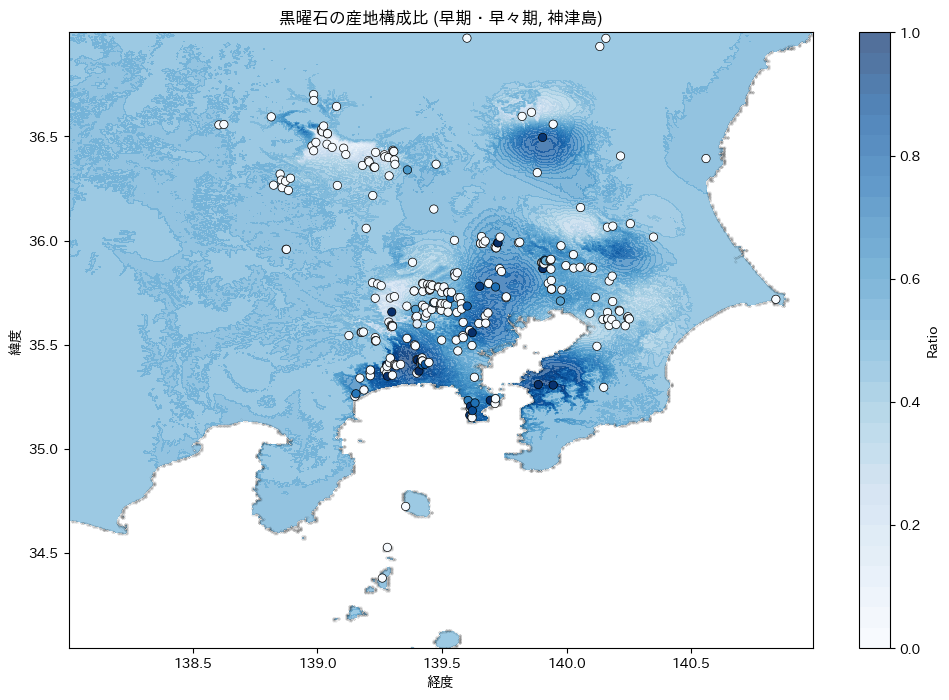

In [34]:
# ------------------------------------------------------------------------------------
# Cell 7 : 可視化
# ------------------------------------------------------------------------------------

# counts_allをaxis=1方向で正規化して、ratio_trueを作成
ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)
# ratio_trueのNaNを0に置き換え
ratio_true = np.nan_to_num(ratio_true)

ratio_sites_df = pl.DataFrame({"遺跡ID": df_sites["遺跡ID"]})

for i, target_origin in enumerate(origin_order[:-1]):
    ratio_sites_df = ratio_sites_df.join(
        pl.DataFrame(
            {
                "遺跡ID": unique_sites["遺跡ID"],
                f"比率_{target_period}_{target_origin}": ratio_true[:, i],
            }
        ),
        on="遺跡ID",
    )
    if f"比率_{target_period}_{target_origin}" in df_sites.columns:
        df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}")
    if f"比率_{target_period}_{target_origin}_right" in df_sites.columns:
        df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}_right")

df_sites = df_sites.join(ratio_sites_df, on="遺跡ID")

ratio_df = pl.DataFrame({"x": lon_mesh.ravel(), "y": lat_mesh.ravel()})

target_period = 0
target_origin_idx = 0
target_origin = origin_order[target_origin_idx]

print(f"target_period: {target_period}, target_origin: {target_origin}")

# ここからtarget_period, target_originに依存する処理

ratio_mesh = pi_grid_mean[:, target_origin_idx].reshape(lon_mesh.shape)

ratio_df = ratio_df.join(
    pl.DataFrame(
        {
            "x": lon_mesh.ravel(),
            "y": lat_mesh.ravel(),
            f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel(),
        }
    ),
    on=["x", "y"],
)

if f"ratio_{target_period}_{target_origin}" in df_elevation.columns:
    df_elevation = df_elevation.drop([f"ratio_{target_period}_{target_origin}"])

if f"ratio_{target_period}_{target_origin}_right" in df_elevation.columns:
    df_elevation = df_elevation.drop([f"ratio_{target_period}_{target_origin}_right"])
df_elevation = df_elevation.join(ratio_df, on=["x", "y"])

fig, ax = plot_contour(
    df_elevation,
    value_col=f"ratio_{target_period}_{target_origin}",
    plot_probability=True,
)

boundary_df = df_elevation.filter(
    pl.col("is_sea") == 0, pl.col("average_elevation").is_null()
)

ax.scatter(boundary_df["x"], boundary_df["y"], c="black", s=0.001)

ax.scatter(
    df_sites["経度"],
    df_sites["緯度"],
    c=df_sites[f"比率_{target_period}_{target_origin}"],
    cmap="Blues",
    edgecolors="black",
    linewidths=0.5,
    vmin=0,
    vmax=1,
)

ax.set_title(f"黒曜石の産地構成比 ({time_period_name[target_period]}, {target_origin})")
plt.show()